# Data Analytics 2

1. Implement logistic regression using Python/R to perform classification on
Social_Network_Ads.csv dataset.
2. Compute Confusion matrix to find TP, FP, TN, FN, Accuracy, Error rate,
Precision, Recall on the given dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
ds = pd.read_csv( "Social_Network_Ads.csv" )
ds

User ID  Gender  Age  EstimatedSalary  Purchased
0    15624510    Male   19            19000          0
1    15810944    Male   35            20000          0
2    15668575  Female   26            43000          0
3    15603246  Female   27            57000          0
4    15804002    Male   19            76000          0
..        ...     ...  ...              ...        ...
395  15691863  Female   46            41000          1
396  15706071    Male   51            23000          1
397  15654296  Female   50            20000          1
398  15755018    Male   36            33000          0
399  15594041  Female   49            36000          1

[400 rows x 5 columns]

## 1. Data Preprocessing

### 1.1. About the dataset

In [3]:
ds.columns

Index(['User ID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased'], dtype='object')

In [4]:
ds.dtypes

User ID             int64
Gender             object
Age                 int64
EstimatedSalary     int64
Purchased           int64
dtype: object

count    400.000000
mean      37.655000
std       10.482877
min       18.000000
25%       29.750000
50%       37.000000
75%       46.000000
max       60.000000
Name: Age, dtype: float64


<Axes: xlabel='Age'>

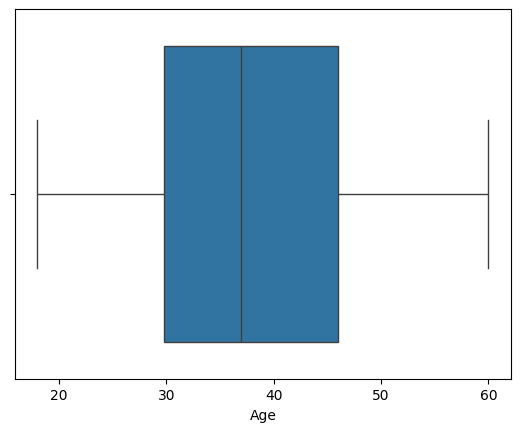

In [5]:
print( ds[ "Age" ].describe() )
sns.boxplot( data=ds , x="Age" )

count       400.000000
mean      69742.500000
std       34096.960282
min       15000.000000
25%       43000.000000
50%       70000.000000
75%       88000.000000
max      150000.000000
Name: EstimatedSalary, dtype: float64


<Axes: xlabel='EstimatedSalary'>

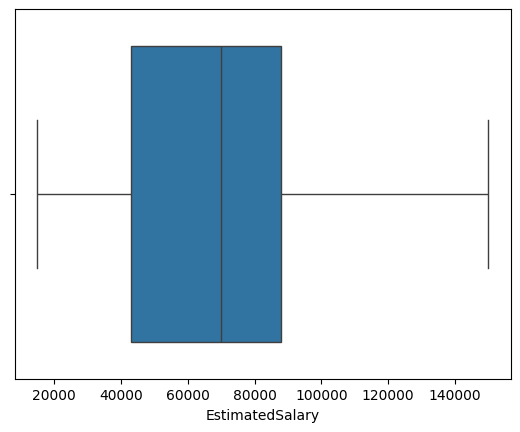

In [6]:
print( ds[ "EstimatedSalary" ].describe() )
sns.boxplot( data=ds , x="EstimatedSalary" )

In [7]:
print( ds[ "Gender" ].value_counts() )
sns.countplot( data=ds , x="Gender" )

Gender
Female    204
Male      196
Name: count, dtype: int64


<Axes: xlabel='Gender', ylabel='count'>

Purchased
0    257
1    143
Name: count, dtype: int64


<Axes: xlabel='Purchased', ylabel='count'>

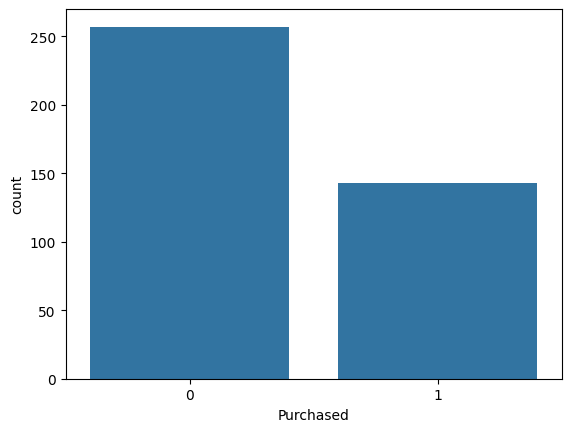

In [8]:
print( ds[ "Purchased" ].value_counts() )
sns.countplot( data=ds , x="Purchased" )

### 1.2. Missing Values

In [9]:
ds.isna().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

### 1.3. Feature Encoding

In [10]:
ds.loc[ ds[ "Gender" ] == "Male" , "Gender" ] = 0
ds.loc[ ds[ "Gender" ] == "Female" , "Gender" ] = 1
ds = ds.astype( { "Gender" : "int" } )

### 1.3. Feature Elimination

In [11]:
# Remove user-id as it is the unique key
ds.drop( [ "User ID" ] , axis=1 , inplace=True )

### 1.4. Normalization


In [12]:
def min_max( feature ):
    ds[ feature ] = ( ds[feature] - ds[feature].min() ) / ( ds[feature].max() - ds[feature].min() ) 

min_max( "EstimatedSalary" )
min_max( "Age" )

### 1.5. Transformation


In [13]:
# Age and EstimatedSalary must be follow a normal distribution
# meaning, skew = kurtosis = 0
ds[ [ "Age" , "EstimatedSalary" ] ].skew()
ds[ [ "Age" , "EstimatedSalary" ] ].kurtosis()

Age               -0.622513
EstimatedSalary   -0.405878
dtype: float64

In [14]:
# Check for transformation with near-zero skew and kurtosis

# Reciprocal transformation
print( ( 1 / (ds["Age"] + 1e-3) ).skew() )
print( ( 1 / (ds["Age"] + 1e-3) ).kurtosis() )

# square-root transformation
print( np.sqrt( ds[ "Age" ] ).skew() )
print( np.sqrt( ds[ "Age" ] ).kurtosis() )

# cube-root transformation
print( np.cbrt( ds[ "Age" ] ).skew() )
print( np.cbrt( ds[ "Age" ] ).kurtosis() )

# log-transformation
print( np.log( ds[ "Age" ] + 1e-6 ).skew() )
print( np.log( ds[ "Age" ] + 1e-6 ).kurtosis() )

8.772648855102862
75.54534474505262
-0.6431799328732787
0.36416628386911043
-1.31598202376335
2.9087199865782383
-6.314913080205095
46.98324920534226


In [15]:
from scipy.stats import boxcox , skew , kurtosis

# Box-cox (power-transform), a common tool to transform
# the distribution of a feature to a Gaussian distribution
# https://www.statisticshowto.com/probability-and-statistics/normal-distributions/box-cox-transformation/
# Add a small number to avoid log(0)
output , lmbda = boxcox( ds[ "Age" ] + 1e-4 )
print( skew(output) )
print( kurtosis(output) )
print( lmbda )

-0.2385769089771854
-0.4060057246641384
0.6805870525685984


In [16]:
# Box-cox transform returns the smallest skew 
# and kurtosis
ds["Age"] = boxcox( ds[ "Age" ] + 1e-4 )[0]
ds["EstimatedSalary"] = boxcox( ds[ "EstimatedSalary" ] + 1e-4 )[0]

In [17]:
ds[ [ "Age" , "EstimatedSalary" ] ].describe()

Age  EstimatedSalary
count  400.000000       400.000000
mean    -0.625744        -0.764688
std      0.335984         0.398289
min     -1.466535        -1.736617
25%     -0.851804        -1.036507
50%     -0.612830        -0.701827
75%     -0.354216        -0.518077
max      0.000100         0.000100

## 2. Model Building

In [18]:
from sklearn.model_selection import train_test_split

y = ds[ "Purchased" ].to_numpy()
X = ds[ [ "EstimatedSalary" , "Age" , "Gender" ] ].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33 )

y_train = np.expand_dims( y_train , axis=1 )
y_test = np.expand_dims( y_test , axis=1 )

print( X_train.shape )
print( X_test.shape )
print( y_train.shape )
print( y_test.shape )

(268, 3)
(132, 3)
(268, 1)
(132, 1)


In [19]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit( X_train , y_train )
pred_y = clf.predict( X_test )

c:\Users\Sumeet\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
# positive -> pred_y = 0
# negative -> pred_y = 1

y_test = np.squeeze( y_test )
tp = ( (pred_y == 0) & (y_test == 0) ).sum()
fp = ( (pred_y == 0) & (y_test == 1) ).sum()
tn = ( (pred_y == 1) & (y_test == 1) ).sum()
fn = ( (pred_y == 1) & (y_test == 0) ).sum()

recall = tp / ( tp + fn )
precision = tp / ( tp + fp )
accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
error = 1 - accuracy
f1 = ( 2 * recall * precision ) / ( precision + recall )

print( "Recall:" , recall ) 
print( "Precision:" , precision ) 
print( "Accuracy:" , accuracy ) 
print( "Error rate:" , error ) 
print( "F1:" , f1 )

Recall: 0.9010989010989011
Precision: 0.9010989010989011
Accuracy: 0.8636363636363636
Error rate: 0.13636363636363635
F1: 0.9010989010989011
